# Trump Press Briefing Analysis

This notebook analyzes the frequency of specific phrases in press briefings to understand key topics and messaging patterns.

## Setup

In [35]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [36]:
INAUGURATION_DATE = datetime(2025, 1, 20)
CONTEXT_WINDOW = 200  # words to display for context

## Define Search Phrases

We'll analyze the following key phrases in press briefings:
Deport
America First
Ukraine
Israel
DOGE / Department of Government Efficiency / Doge
Russia
Elon / Musk
Inflation
Fraud
Intelligence
Crypto
Lawsuit
Egg
GM
Interest Rate
CBS
Ford
Chrysler
Debt Ceiling
Sylvester / Turner

In [47]:
SEARCH_PHRASES = {
    'Deport': r'\b(deport|deports)\b',
    'Deportation': r'\b(deportation|deportations)\b',
    'America First': r'\b(america\s+first)\b',
    'Ukraine': r'\b(ukraine|ukraine\'s|ukraines)\b',
    'Israel': r'\b(israel|israel\'s|israels)\b',
    'DOGE': r'\b(doge|doge\'s|doges|department\s+of\s+government\s+efficiency|department\s+of\s+government\s+efficiency\'s)\b',
    'Russia': r'\b(russia|russia\'s|russias)\b',
    'Elon': r'\b(elon musk|elon musk\'s|elon|elon\'s|elons|musk|musk\'s|musks)\b',
    'Inflation': r'\b(inflation|inflation\'s|inflations)\b',
    'Fraud': r'\b(fraud|frauds|fraud\'s)\b',
    'Intelligence': r'\b(intelligence|intelligences|intelligence\'s)\b',
    'Crypto': r'\b(crypto|cryptos|crypto\'s|)\b',
    'Lawsuit': r'\b(lawsuit|lawsuits|lawsuit\'s)\b',
    'Egg': r'\b(egg|eggs|egg\'s)\b',
    'GM': r'\b(gm|gm\'s)\b',
    'Interest Rate': r'\b(interest\s+rate|interest\s+rates)\b',
    'CBS': r'\b(cbs|cbs\'s)\b',
    'Ford': r'\b(ford|ford\'s|fords)\b',
    'Chrysler': r'\b(chrysler|chrysler\'s|chryslers)\b',
    'Debt Ceiling': r'\b(debt\s+ceiling|debt\s+ceilings)\b',
    'Sylvester': r'\b(sylvester|sylvester\'s|sylvesters|turner|turner\'s|turners)\b'
}

In [48]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process transcripts from press briefing directory only"""
    results = []
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        if category != 'press briefing':  # Only process press briefings
            continue
            
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    return pd.DataFrame(results)

In [49]:
# Process press briefing transcripts
df = process_directory('../data/processed-transcripts')
df = df.sort_values('date')

# Split data by date 
df_pre = df[df['date'] < INAUGURATION_DATE]
df_post = df[df['date'] >= INAUGURATION_DATE]

# Print dataset statistics
print("Dataset Statistics:")
print(f"Pre-inauguration briefings: {len(df_pre)}")
print(f"Post-inauguration briefings: {len(df_post)}")

print("\nWord Count Statistics:")
print(f"Pre-inauguration average length: {df_pre['text_length'].mean():.0f} words")
print(f"Post-inauguration average length: {df_post['text_length'].mean():.0f} words")

print("\nDate Ranges:")
# Handle NaT values when printing date ranges
pre_min = df_pre['date'].min()
pre_max = df_pre['date'].max()
print("Pre-inauguration: ", end='')
if pd.notna(pre_min) and pd.notna(pre_max):
    print(f"{pre_min.strftime('%Y-%m-%d')} to {pre_max.strftime('%Y-%m-%d')}")
else:
    print("No valid dates")

if not df_post.empty:
    post_min = df_post['date'].min()
    post_max = df_post['date'].max() 
    print("Post-inauguration: ", end='')
    if pd.notna(post_min) and pd.notna(post_max):
        print(f"{post_min.strftime('%Y-%m-%d')} to {post_max.strftime('%Y-%m-%d')}")
    else:
        print("No valid dates")

Dataset Statistics:
Pre-inauguration briefings: 0
Post-inauguration briefings: 7

Word Count Statistics:
Pre-inauguration average length: nan words
Post-inauguration average length: 4397 words

Date Ranges:
Pre-inauguration: No valid dates
Post-inauguration: 2025-01-28 to 2025-03-05


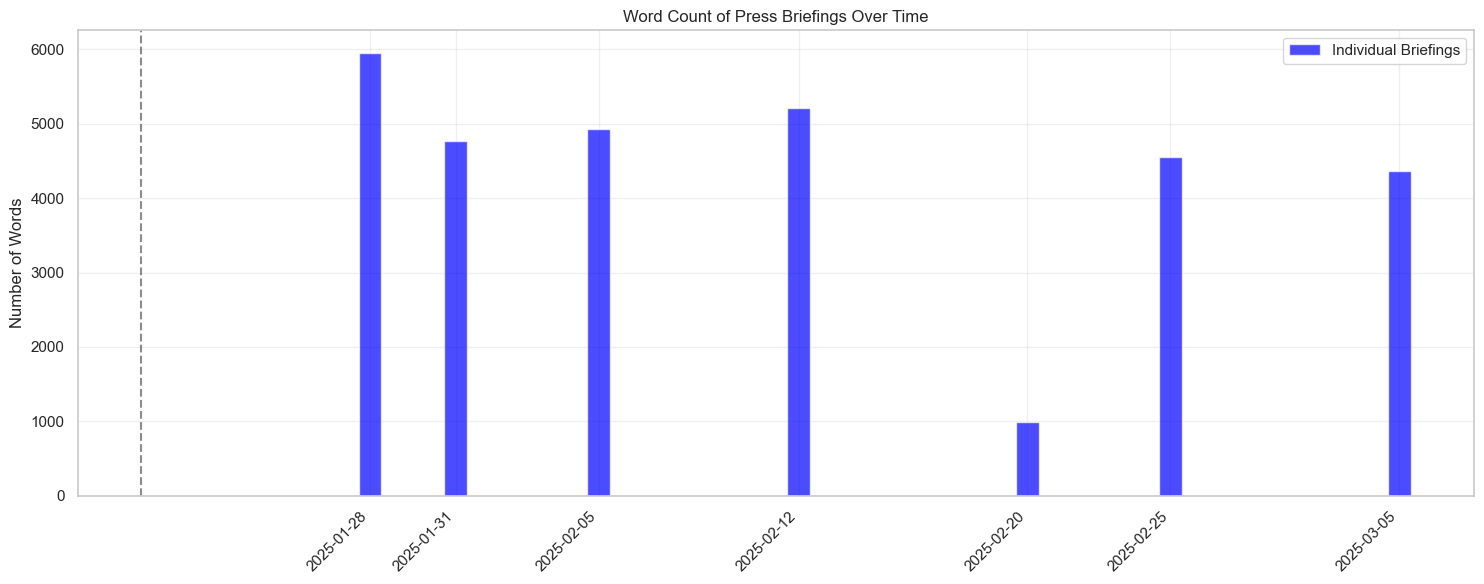


Word Count Summary:
Mean word count: 4397
Median word count: 4774
Min word count: 985
Max word count: 5958


In [50]:
# Plot total word counts over time as a bar chart
plt.figure(figsize=(15, 6))

# Create bar plot
bars = plt.bar(df['date'], df['text_length'], alpha=0.7, color='blue', label='Individual Briefings')

# Format x-axis with rotated date labels
plt.xticks(df['date'], [d.strftime('%Y-%m-%d') for d in df['date']], rotation=45, ha='right')

plt.title('Word Count of Press Briefings Over Time')
plt.xlabel('') # Remove x-axis label since dates are shown
plt.ylabel('Number of Words')
plt.legend()
plt.grid(True, alpha=0.3)

# Add vertical line for inauguration
plt.axvline(x=INAUGURATION_DATE, color='k', linestyle='--', alpha=0.5, label='Inauguration')

# Set y-axis to start at 0
plt.ylim(bottom=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nWord Count Summary:")
print(f"Mean word count: {df['text_length'].mean():.0f}")
print(f"Median word count: {df['text_length'].median():.0f}")
print(f"Min word count: {df['text_length'].min():.0f}")
print(f"Max word count: {df['text_length'].max():.0f}")


## Phrase Frequency Analysis

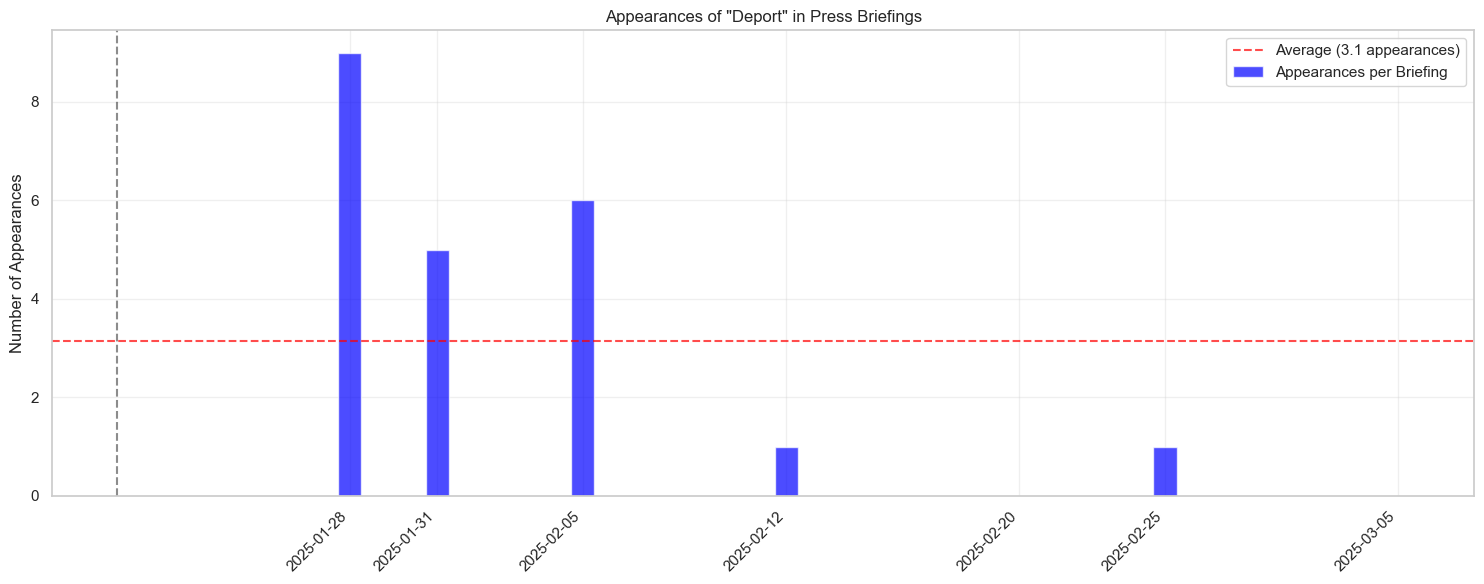

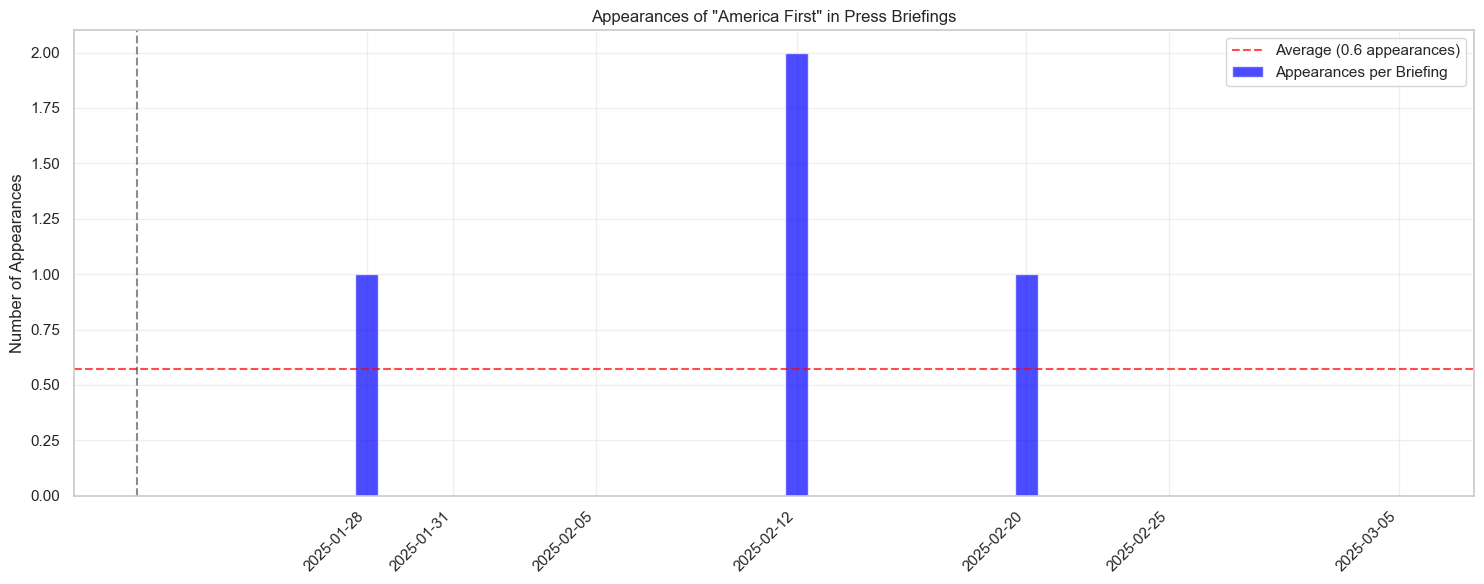

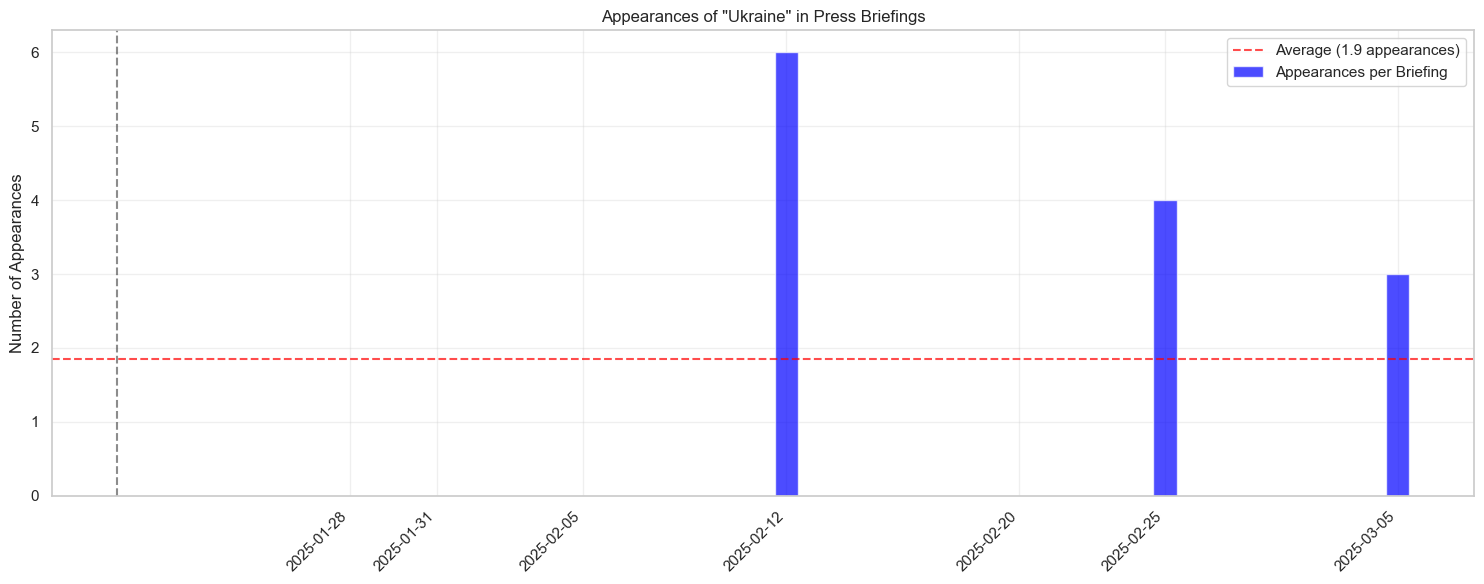

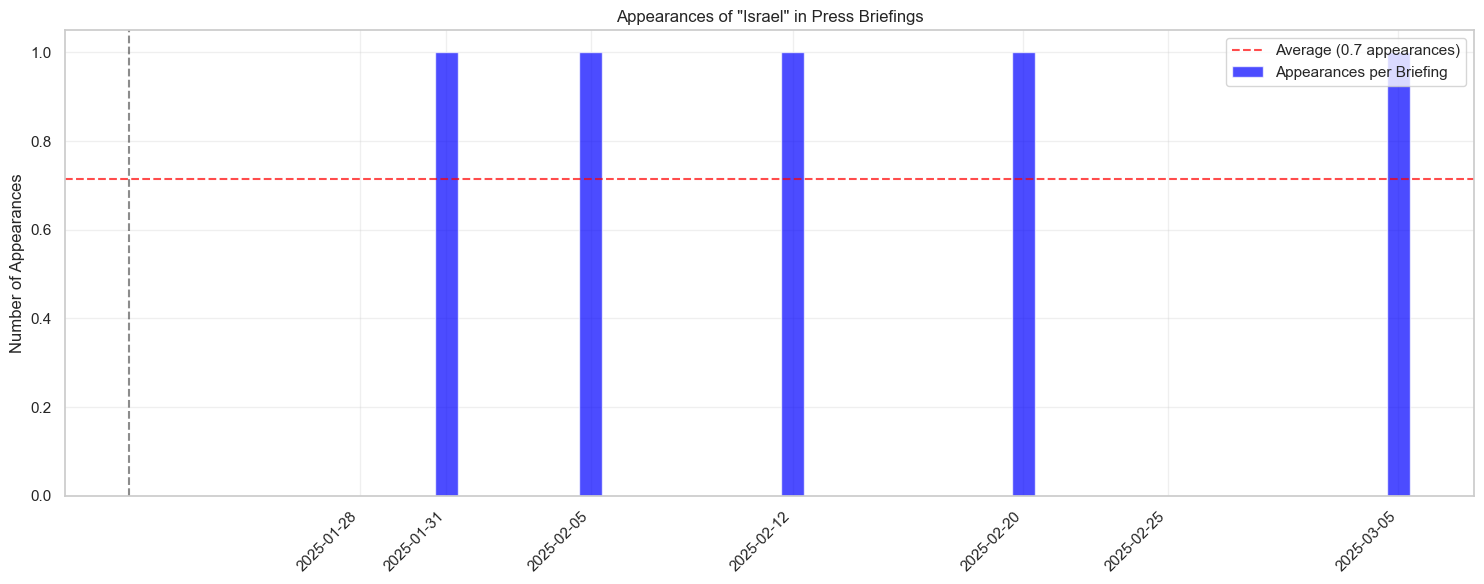

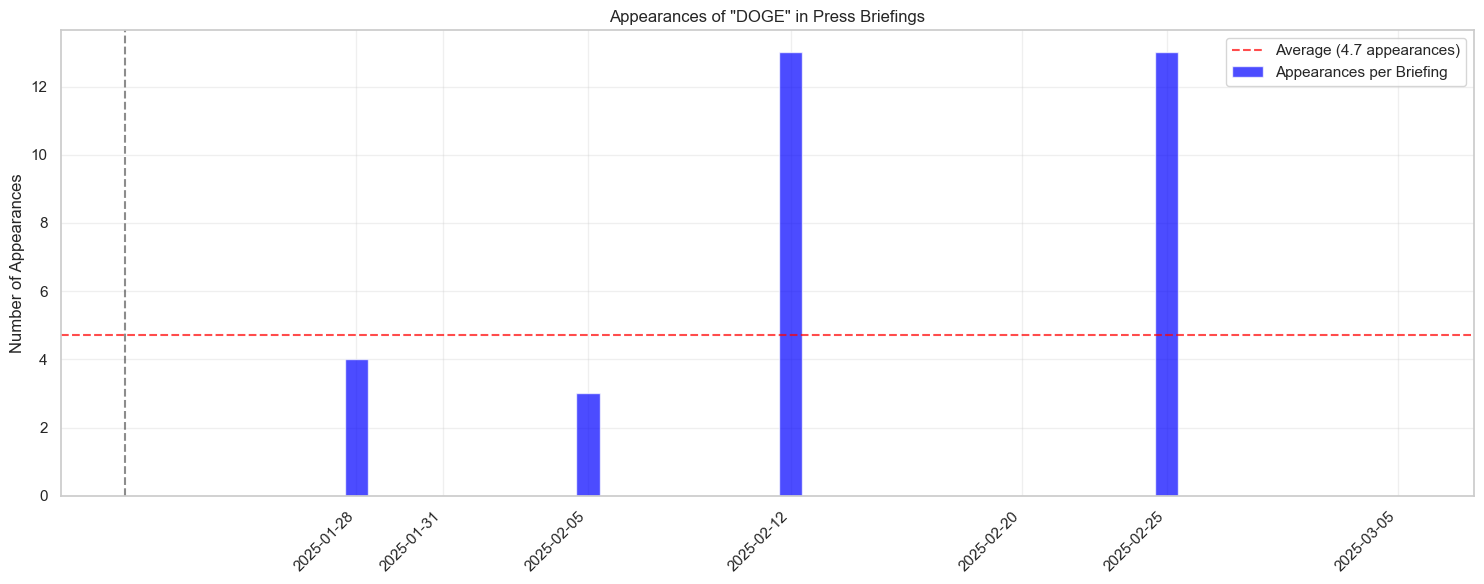

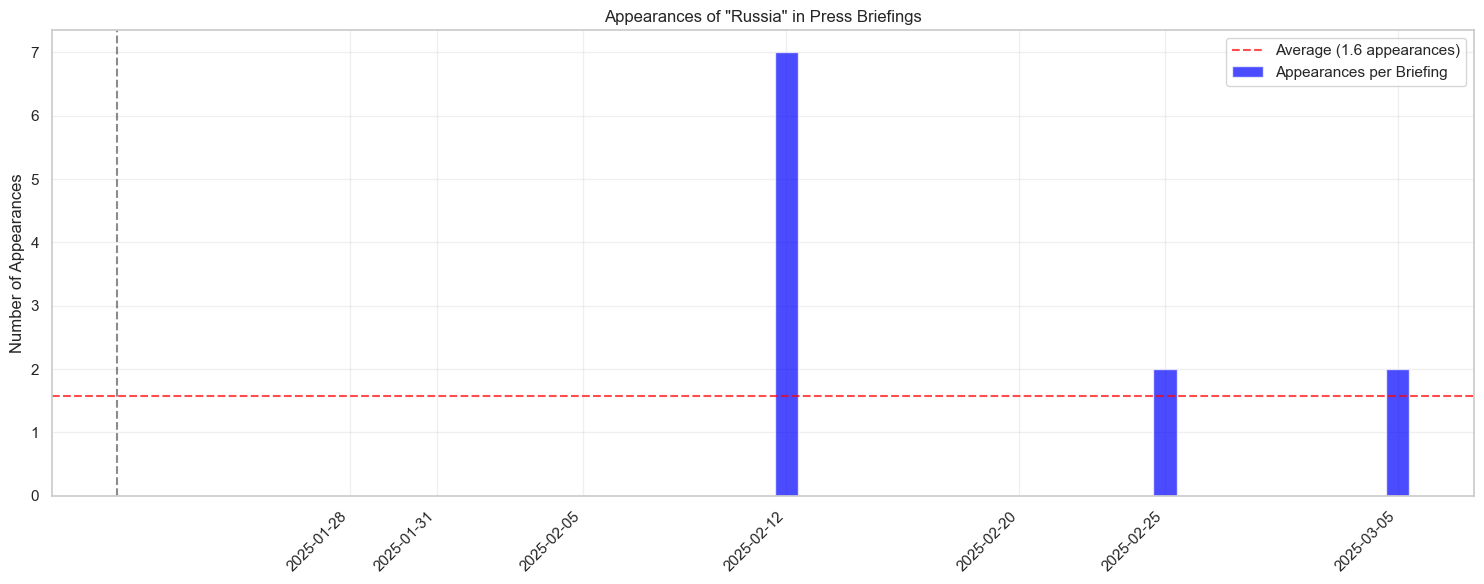

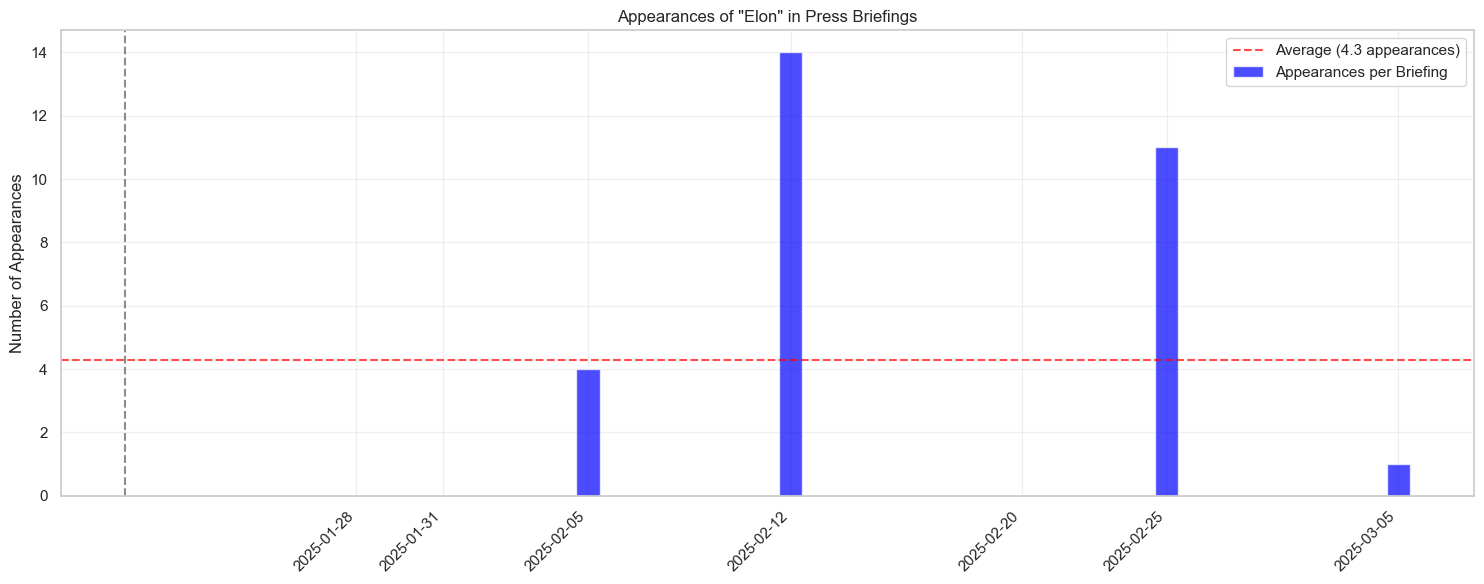

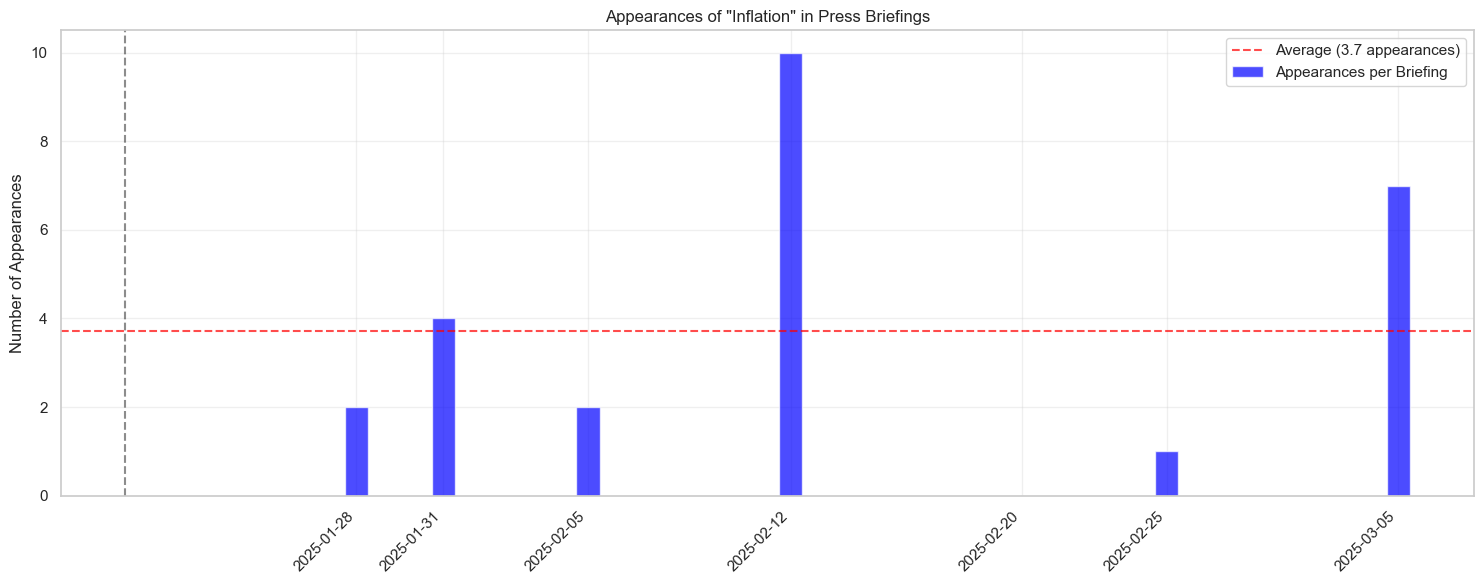

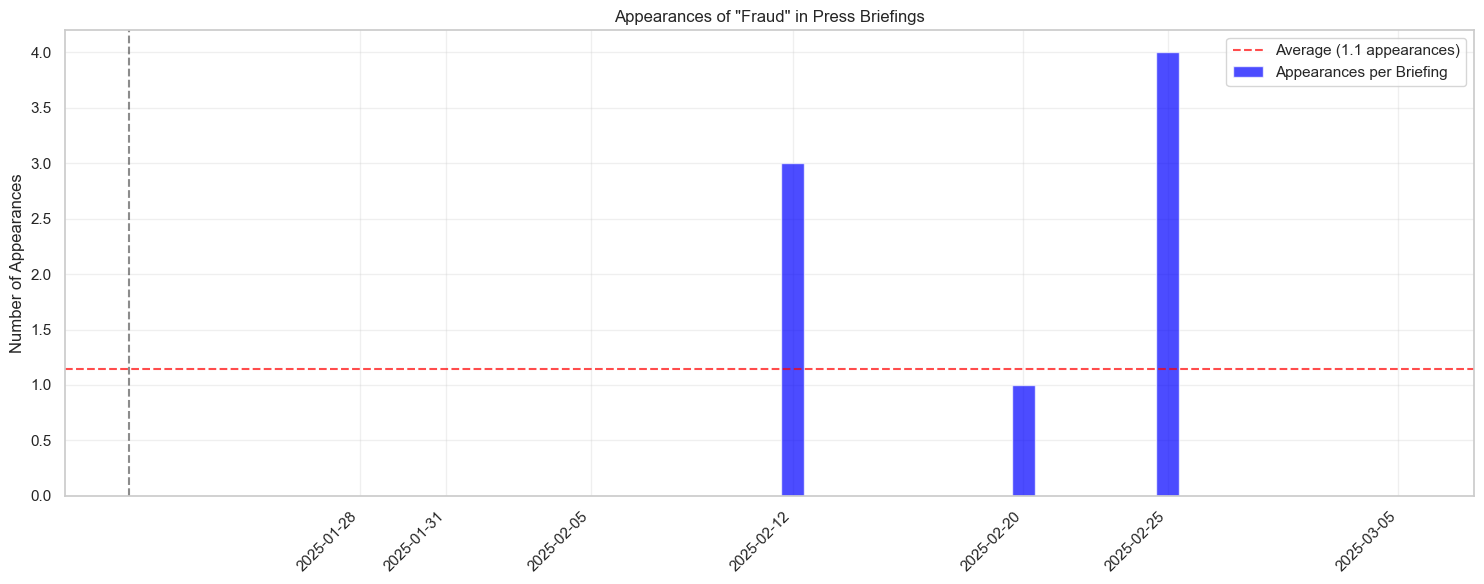

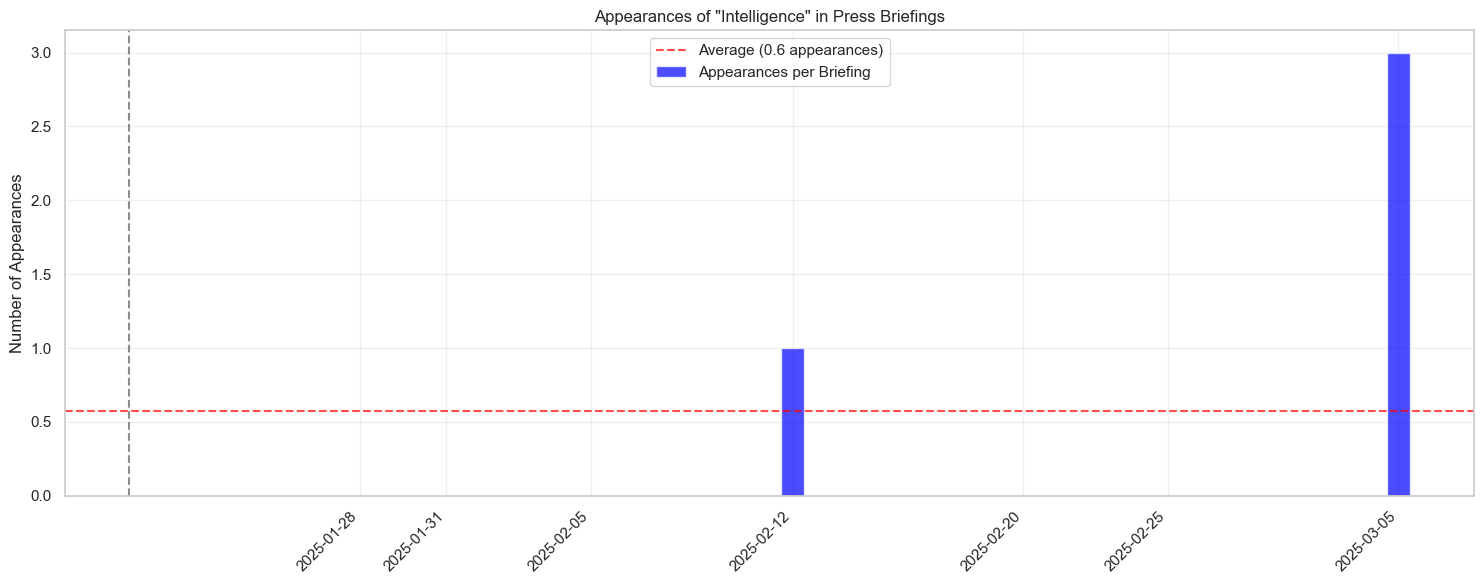

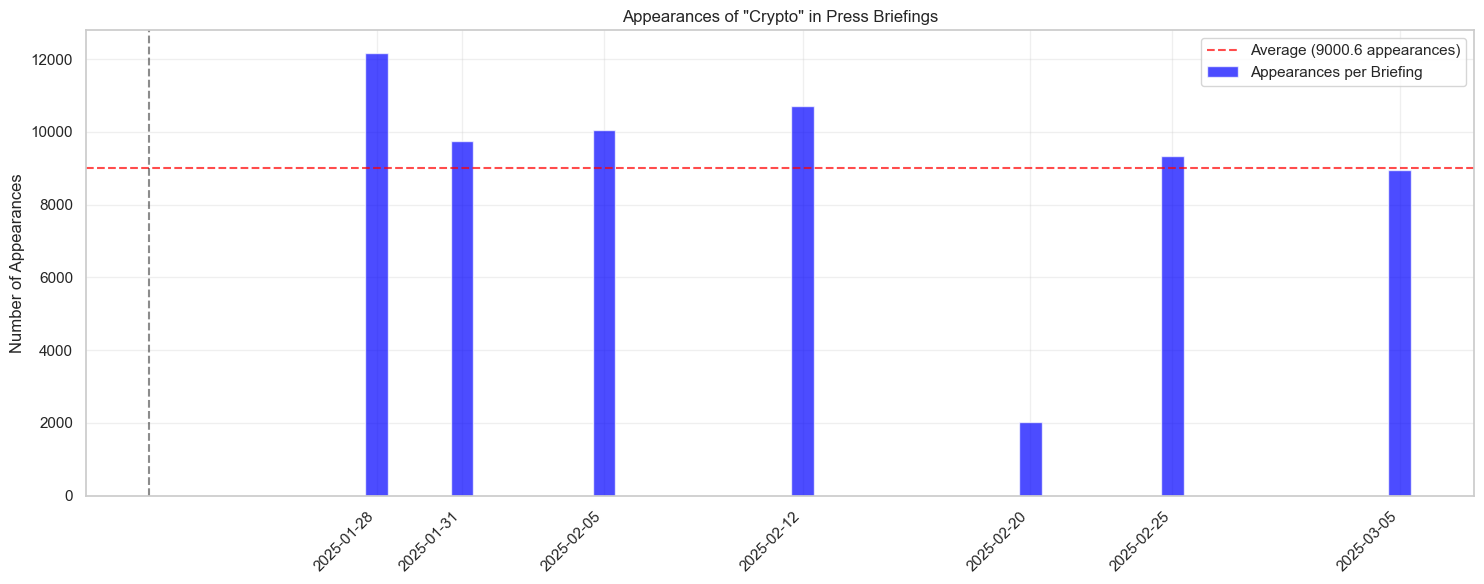

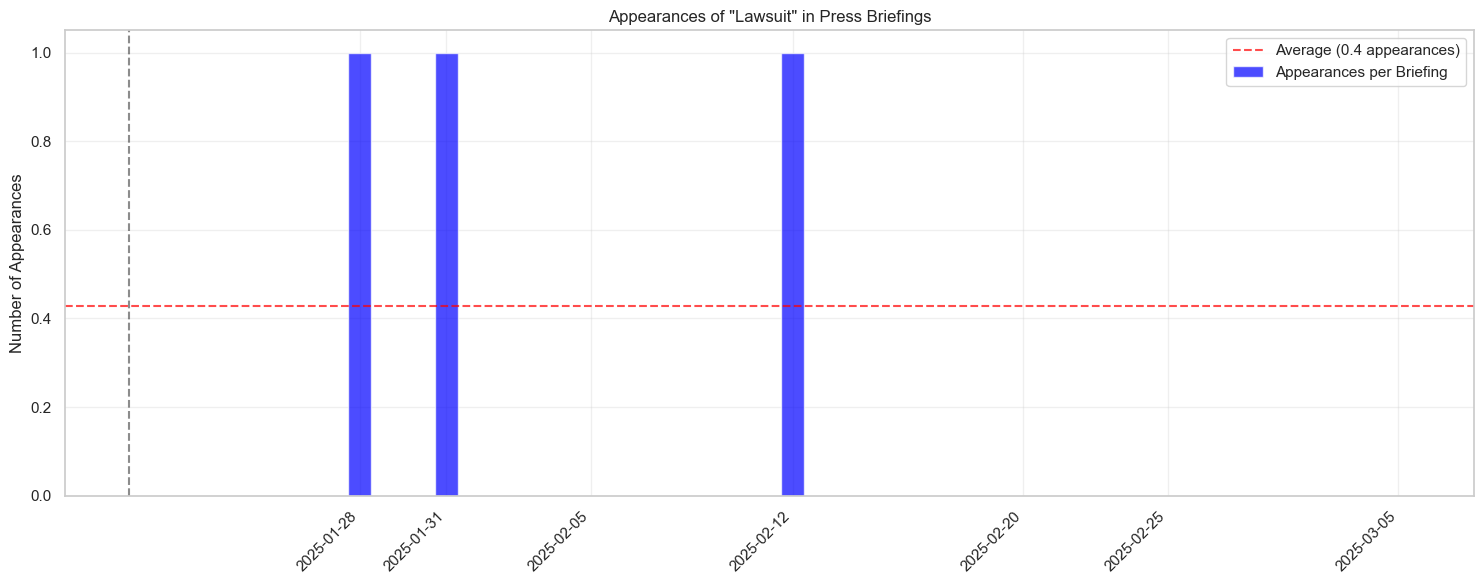

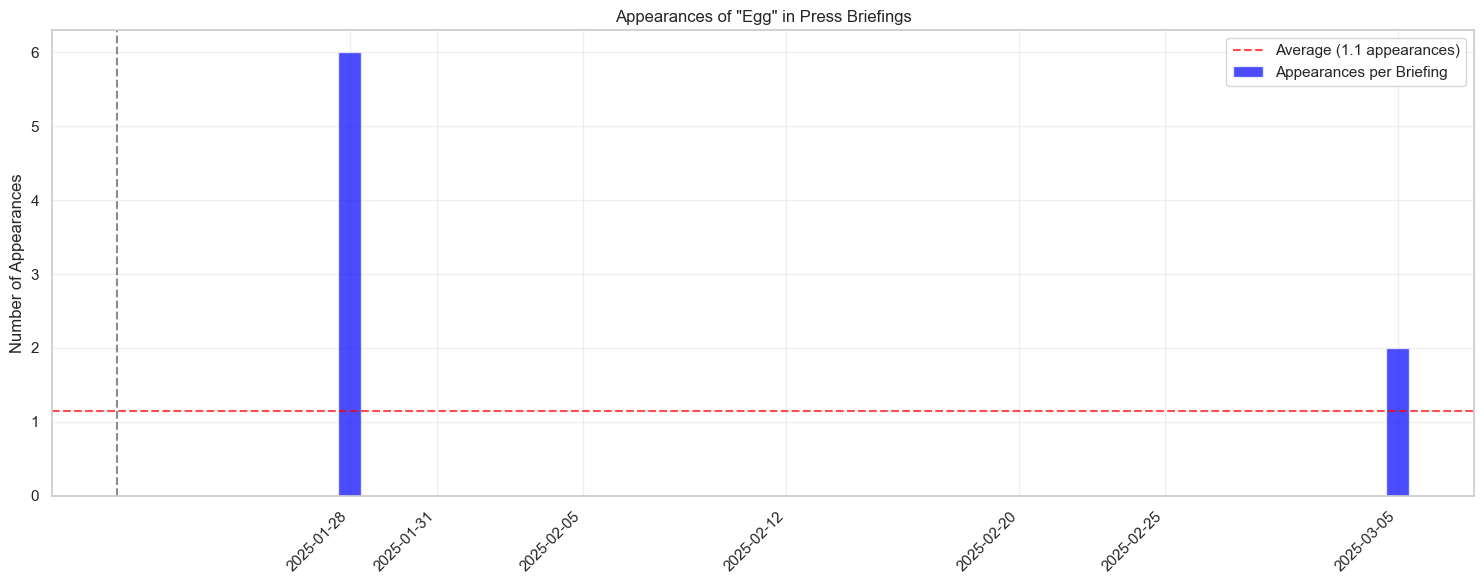

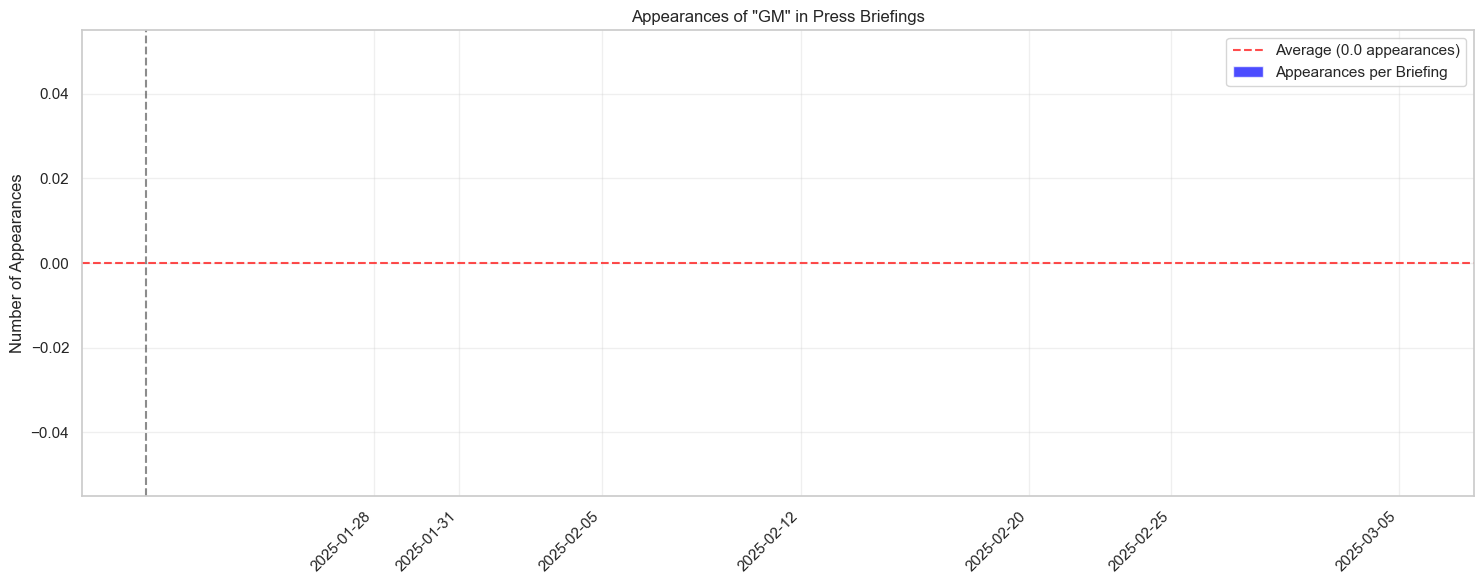

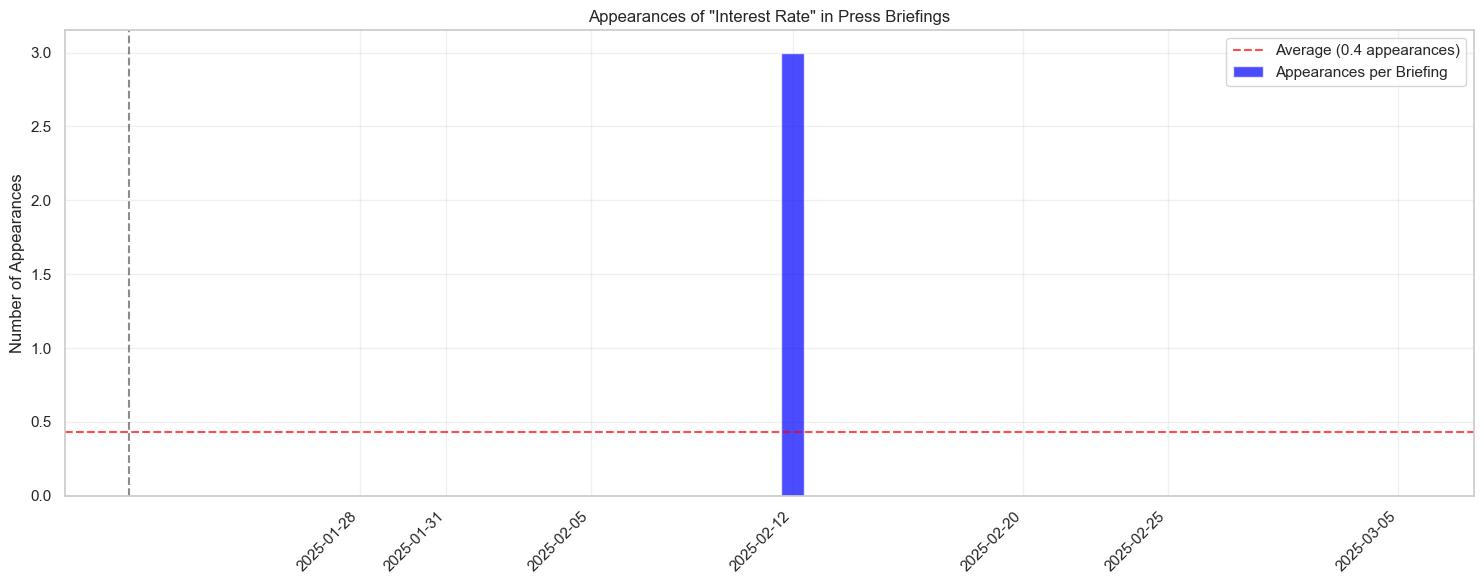

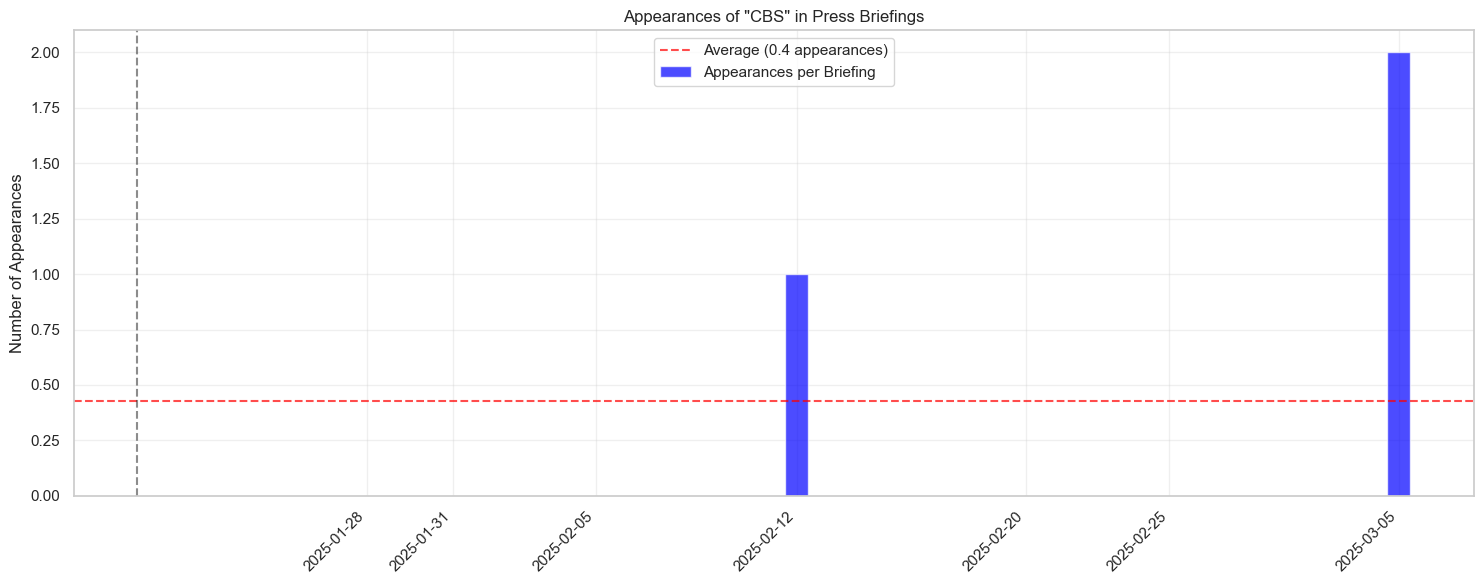

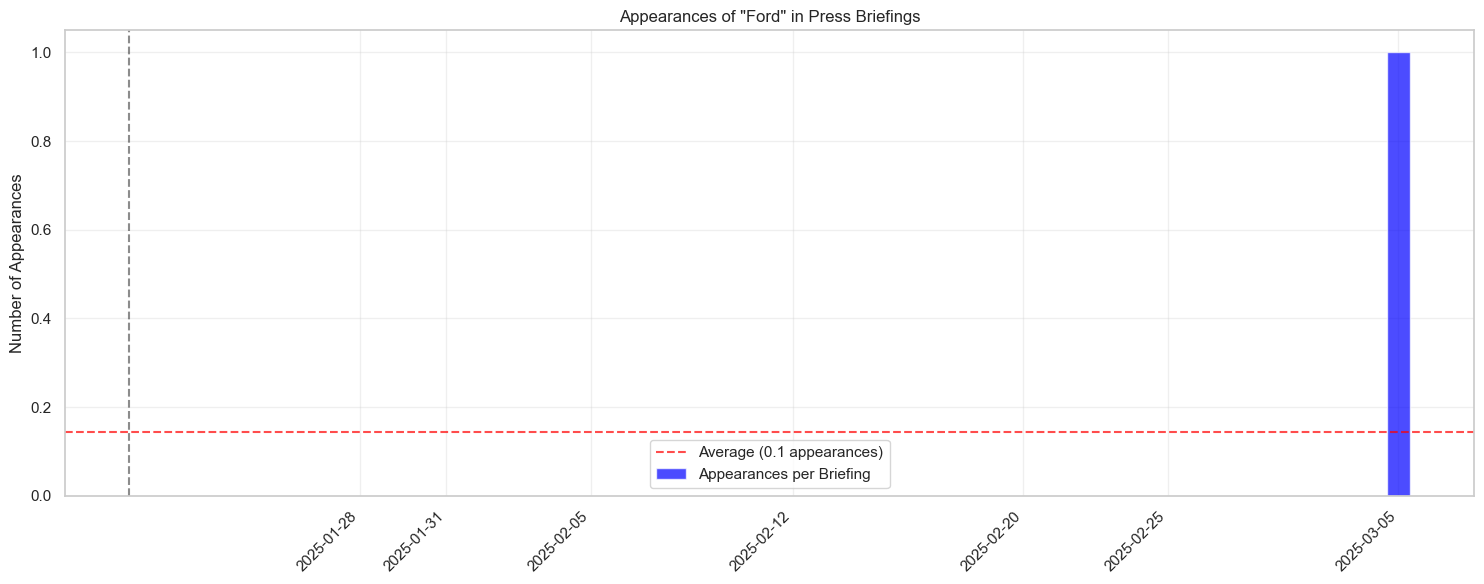

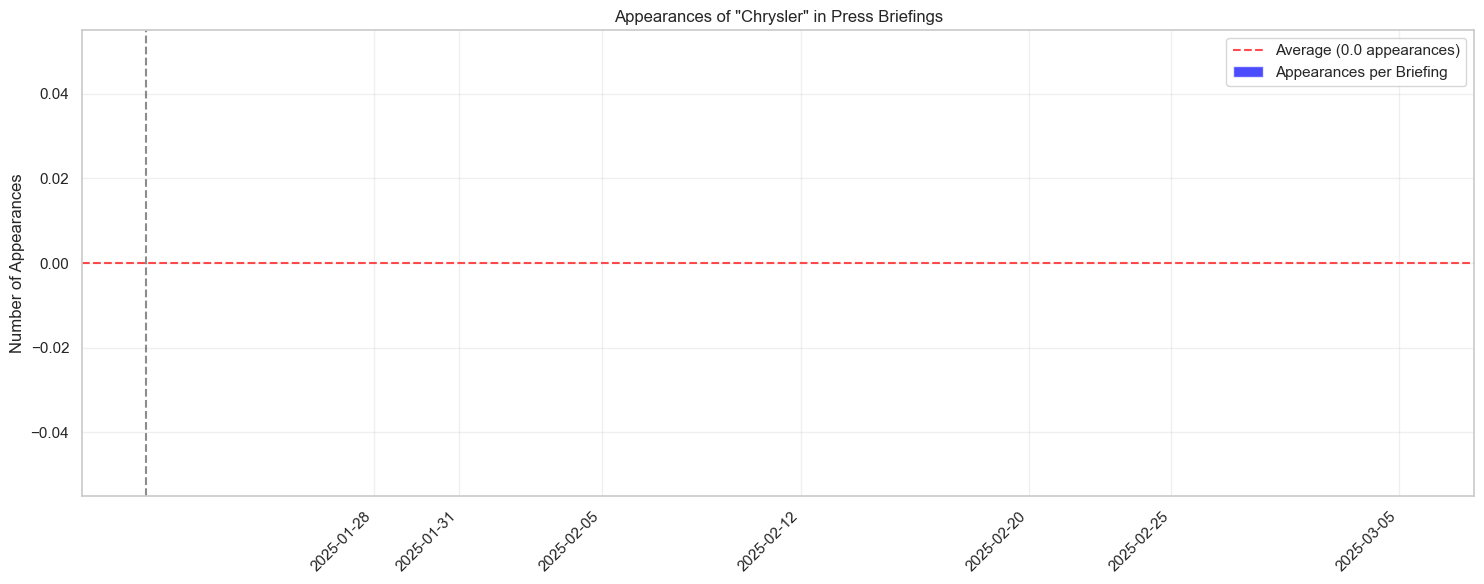

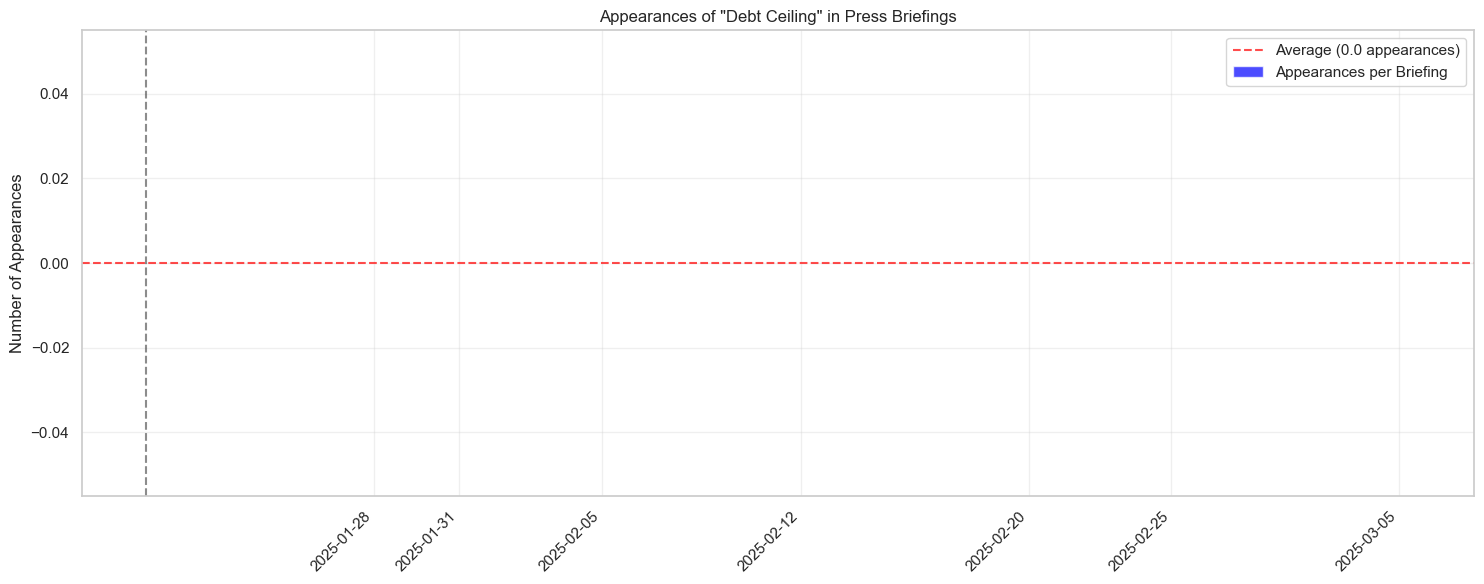

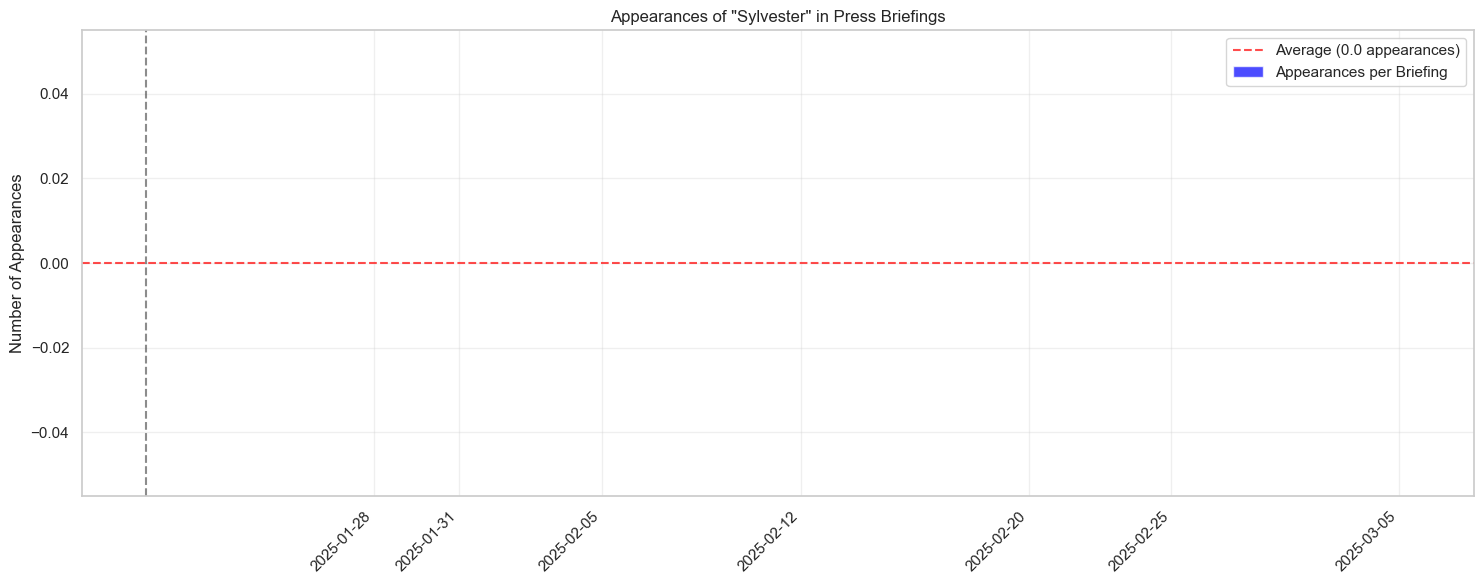

In [51]:
def plot_phrase_frequency_over_time(df, phrase):
    """Plot the frequency of a phrase over time"""
    plt.figure(figsize=(15, 6))
    
    # Get raw counts and dates
    counts = df[phrase]
    dates = df['date']
    
    # Calculate average
    avg = counts.mean()
    
    # Create bar plot
    bars = plt.bar(dates, counts, alpha=0.7, color='blue', label='Appearances per Briefing')
    
    # Add horizontal line for average
    plt.axhline(y=avg, color='red', linestyle='--', alpha=0.7, 
                label=f'Average ({avg:.1f} appearances)')
    
    # Format x-axis with rotated date labels
    plt.xticks(dates, [d.strftime('%Y-%m-%d') for d in dates], rotation=45, ha='right')
    
    plt.title(f'Appearances of "{phrase}" in Press Briefings')
    plt.xlabel('')  # Remove x-axis label since dates are shown
    plt.ylabel('Number of Appearances')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical line for inauguration
    plt.axvline(x=INAUGURATION_DATE, color='k', linestyle='--', alpha=0.5, label='Inauguration')
    
    plt.tight_layout()
    plt.show()

# Plot time series for all phrases
for phrase in SEARCH_PHRASES.keys():
    plot_phrase_frequency_over_time(df, phrase)

## Recent Usage in Context

In [42]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    all_matches = []
    
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')}")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Elon' ===

Date: 2025-02-25
Context: ...etary Rubio has spoken on this extensively as well.

So, a couple of things on this. First of all, let's just take a step back and talk about this idea. The president sent out a tweet last weekend to Elon Musk saying he loves everything Elon is doing, and he wants him to be even more aggressive, because DOGE thus far has proven incredibly successful in making our government more efficient.

And so, El...

Date: 2025-02-25
Context: ... Rubio has spoken on this extensively as well.

So, a couple of things on this. First of all, let's just take a step back and talk about this idea. The president sent out a tweet last weekend to Elon Musk saying he loves everything Elon is doing, and he wants him to be even more aggressive, because DOGE thus far has proven incredibly successful in making our government more efficient.

And so, Elon an...

Date: 2025-02-25
Context: ...ively as well.

So, a couple of things on this. First of all, 

## Phrase Co-occurrence Analysis

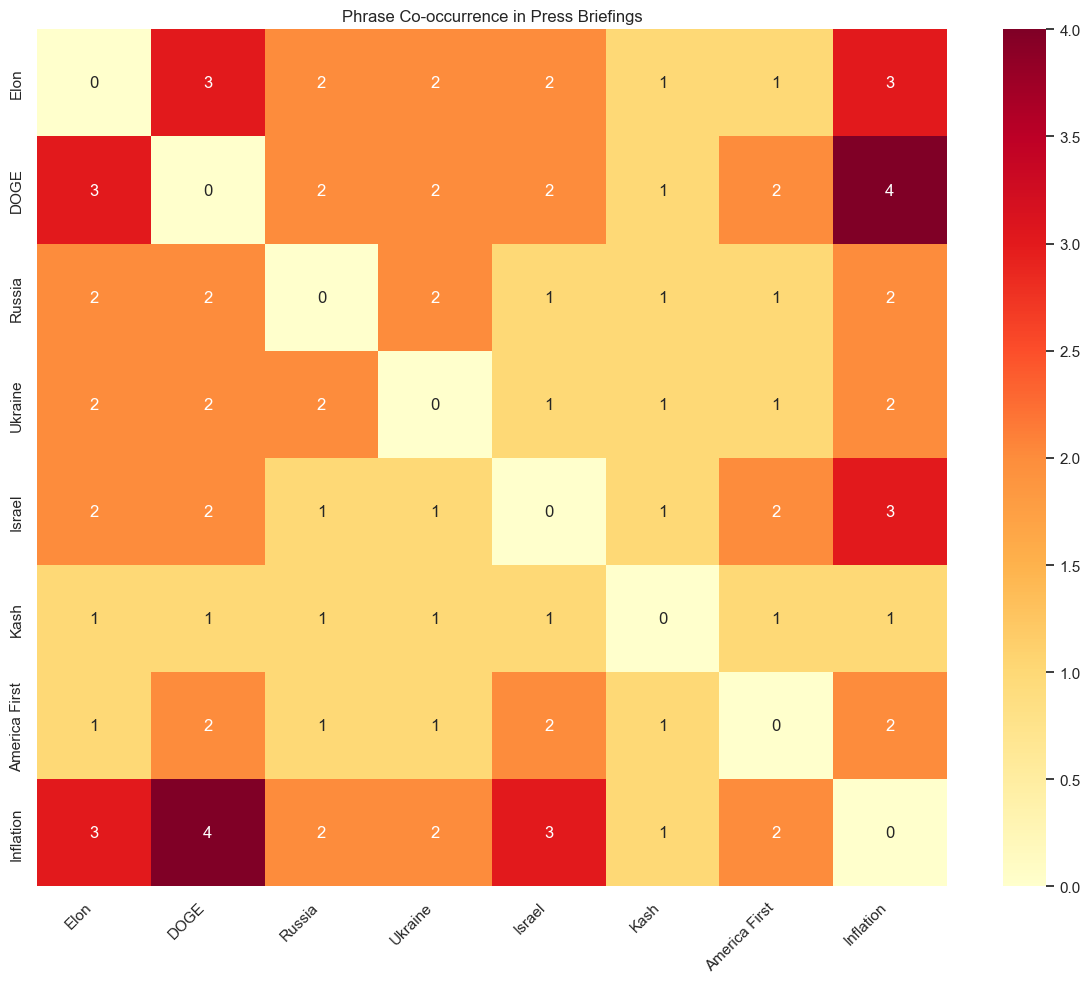

In [43]:
# Create co-occurrence matrix
phrase_cols = list(SEARCH_PHRASES.keys())
cooccurrence = np.zeros((len(phrase_cols), len(phrase_cols)))

for i, phrase1 in enumerate(phrase_cols):
    for j, phrase2 in enumerate(phrase_cols):
        if i != j:
            # Count briefings where both phrases appear
            cooccurrence[i,j] = ((df[phrase1] > 0) & (df[phrase2] > 0)).sum()

# Create and display heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence, 
            xticklabels=phrase_cols,
            yticklabels=phrase_cols,
            annot=True,
            fmt='.0f',
            cmap='YlOrRd')
plt.title('Phrase Co-occurrence in Press Briefings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Phrase Usage Statistics

In [44]:
# Calculate statistics for each phrase
stats_data = []

for phrase in SEARCH_PHRASES.keys():
    stats = {
        'Phrase': phrase,
        'Total Mentions': df[phrase].sum(),
        'Briefings with Mentions': (df[phrase] > 0).sum(),
        'Percentage of Briefings': (df[phrase] > 0).mean() * 100,
        'Average per Briefing': df[phrase].mean(),
        'Max in Single Briefing': df[phrase].max()
    }
    stats_data.append(stats)

stats_df = pd.DataFrame(stats_data)
stats_df = stats_df.sort_values('Total Mentions', ascending=False)

# Format the table
stats_df['Percentage of Briefings'] = stats_df['Percentage of Briefings'].round(1).astype(str) + '%'
stats_df['Average per Briefing'] = stats_df['Average per Briefing'].round(2)

display(stats_df)

,Phrase,Total Mentions,Briefings with Mentions,Percentage of Briefings,Average per Briefing,Max in Single Briefing
0,Elon,45,3,50.0%,7.50,24
1,DOGE,32,4,66.7%,5.33,13
7,Inflation,19,5,83.3%,3.17,10
3,Ukraine,10,2,33.3%,1.67,6
2,Russia,9,2,33.3%,1.50,7
4,Israel,4,4,66.7%,0.67,1
6,America First,4,3,50.0%,0.67,2
5,Kash,2,2,33.3%,0.33,1
